In [1]:
# Menginstall library ultralytics untuk YOLOv8
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 37.1 MB/s eta 0:00:00


In [25]:
# Mengimpor library yang dibutuhkan
from google.colab import drive  # Untuk menghubungkan Google Drive
from google.colab import files  # Untuk mengunggah file ke Colab
import zipfile  # Untuk ekstraksi file ZIP
import os  # Untuk operasi file dan direktori
from PIL import Image  # Untuk manipulasi gambar
import numpy as np  # Untuk operasi numerik
import yaml  # Untuk membaca dan menulis file YAML
from ultralytics import YOLO  # Untuk model YOLO
import cv2  # Untuk operasi gambar
import matplotlib.pyplot as plt  # Untuk visualisasi data
import random # Untuk warna acak pada box hasil deteksi

In [3]:
# Mount Google Drive agar dapat mengakses file di dalam Gdrive
drive.mount('/content/drive')

# Menentukan path file ZIP dataset dan direktori
zip_path = '/content/drive/MyDrive/dataset/garbage detection.v2i.yolov8.zip'
extract_path = '/content/drive/MyDrive/dataset/garbage_detection_yolov8_notzip'

# Mengekstraksi file ZIP dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Menampilkan pesan bahwa dataset berhasil diekstrak
print("Dataset extracted successfully.")

Mounted at /content/drive
Dataset extracted successfully.


In [4]:
# Menentukan path root dari dataset yang sudah diekstrak
dataset_root = '/content/drive/MyDrive/dataset/garbage_detection_yolov8_notzip'

# Menentukan subdirektori untuk train, valid, dan test
splits = ['train', 'valid', 'test']

# Fungsi untuk menghitung jumlah file label di setiap kelas
def count_files_in_classes(split_path):
    class_counts = {}  # Dictionary untuk menyimpan jumlah file per kelas
    labels_path = os.path.join(split_path, 'labels')

    for label_file in os.listdir(labels_path):  # Iterasi setiap file label
        file_path = os.path.join(labels_path, label_file)
        with open(file_path, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])  # Mengambil class_id dari baris
                if class_id not in class_counts:
                    class_counts[class_id] = 0
                class_counts[class_id] += 1

    return class_counts

# Menghitung jumlah file label untuk setiap split (train, valid, test)
for split in splits:
    split_path = os.path.join(dataset_root, split)
    print(f"Jumlah file di setiap kelas (split: {split}):")
    try:
        class_counts = count_files_in_classes(split_path)
        for class_id, count in class_counts.items():
            print(f"  Class {class_id}: {count} files")
    except FileNotFoundError:
        print(f"  Labels folder not found for {split}!")

Jumlah file di setiap kelas (split: train):
  Class 1: 784 files
  Class 4: 1188 files
  Class 2: 1661 files
  Class 0: 422 files
  Class 3: 1020 files
  Class 6: 2626 files
  Class 5: 699 files
Jumlah file di setiap kelas (split: valid):
  Class 3: 85 files
  Class 4: 151 files
  Class 1: 230 files
  Class 0: 108 files
  Class 2: 250 files
  Class 5: 218 files
  Class 6: 741 files
Jumlah file di setiap kelas (split: test):
  Class 1: 136 files
  Class 2: 260 files
  Class 0: 68 files
  Class 3: 170 files
  Class 4: 185 files
  Class 6: 382 files
  Class 5: 112 files


In [5]:
# Memeriksa konsistensi antara file gambar dan label
for split in splits:
    images_path = os.path.join(dataset_root, split, 'images')
    labels_path = os.path.join(dataset_root, split, 'labels')

    # Mendapatkan daftar file gambar dan label tanpa ekstensi
    image_files = set([os.path.splitext(f)[0] for f in os.listdir(images_path) if f.endswith('.jpg')])
    label_files = set([os.path.splitext(f)[0] for f in os.listdir(labels_path) if f.endswith('.txt')])

    # Menemukan file yang tidak memiliki pasangan
    missing_labels = image_files - label_files
    missing_images = label_files - image_files

    # Menampilkan pesan jika ada file yang tidak konsisten
    if missing_labels:
        print(f"[{split}] Missing labels for images: {missing_labels}")
    if missing_images:
        print(f"[{split}] Missing images for labels: {missing_images}")
    # Jika semua konsisten
    if not missing_labels and not missing_images:
        print(f"[{split}] All images and labels are consistent.")

[train] All images and labels are consistent.
[valid] All images and labels are consistent.
[test] All images and labels are consistent.


In [6]:
# Fungsi untuk mengonversi semua gambar ke format .jpg
def convert_images_to_jpg(images_path):
    for file_name in os.listdir(images_path):
        file_path = os.path.join(images_path, file_name)
        if not file_name.endswith('.jpg'):
            img = Image.open(file_path)
            new_file_path = os.path.splitext(file_path)[0] + '.jpg'
            img.convert('RGB').save(new_file_path, 'JPEG')
            os.remove(file_path)  # Menghapus file asli
            print(f"Converted {file_name} to JPG.")

# Mengonversi gambar pada setiap split
for split in splits:
    images_path = os.path.join(dataset_root, split, 'images')
    convert_images_to_jpg(images_path)

In [7]:
# Fungsi untuk mengubah ukuran gambar ke 640x640
def resize_images(images_path, target_size=(640, 640)):
    for file_name in os.listdir(images_path):
        file_path = os.path.join(images_path, file_name)
        img = Image.open(file_path)
        img_resized = img.resize(target_size)  # Mengubah ukuran gambar
        img_resized.save(file_path)
        print(f"Resized {file_name} to {target_size}.")

# Mengubah ukuran gambar pada setiap split
for split in splits:
    images_path = os.path.join(dataset_root, split, 'images')
    resize_images(images_path)

Resized 159710235_mp4-0_jpg.rf.8c7d00b935ac48ee9fb68fff18a350e1.jpg to (640, 640).
Resized 159710235_mp4-10_jpg.rf.fc05a50d237515ecac056910c79bf6cf.jpg to (640, 640).
Resized 159710235_mp4-11_jpg.rf.0249445458944f8f7c17628aa7e3fc3d.jpg to (640, 640).
Resized 159710235_mp4-12_jpg.rf.db6b064796f8642baf0e9bb2c954c386.jpg to (640, 640).
Resized 159710235_mp4-1_jpg.rf.4897c21e16005054ab4b162dfb827447.jpg to (640, 640).
Resized 159710235_mp4-3_jpg.rf.13fac656f5debdc4805e64cc33a69969.jpg to (640, 640).
Resized 159710235_mp4-4_jpg.rf.69a67deb57ef5557f9a40f7a194cda80.jpg to (640, 640).
Resized 159710235_mp4-5_jpg.rf.c66c330023d798ee74885161538e5122.jpg to (640, 640).
Resized 159710235_mp4-6_jpg.rf.11cf9049d41867d2631ac6d922fe12d1.jpg to (640, 640).
Resized 159710235_mp4-8_jpg.rf.d4dbc8e8b57cab33207d24863809fe9e.jpg to (640, 640).
Resized 159866174_mp4-1_jpg.rf.e22ffaa4197504e37868e7434ee3eea9.jpg to (640, 640).
Resized 159866174_mp4-2_jpg.rf.1457f3f4c48fd0048c96aae71b09ee84.jpg to (640, 640).
R

In [8]:
# Fungsi untuk menghapus file gambar atau label yang kosong
def remove_corrupted_files(images_path, labels_path):
    for file_name in os.listdir(images_path):
        file_path = os.path.join(images_path, file_name)
        try:
            img = Image.open(file_path)
            img.verify()  # Memeriksa validitas gambar
        except (IOError, SyntaxError):
            os.remove(file_path)
            print(f"Removed corrupted image: {file_name}")

    for file_name in os.listdir(labels_path):
        file_path = os.path.join(labels_path, file_name)
        if os.stat(file_path).st_size == 0:  # Memeriksa jika file kosong
            os.remove(file_path)  # Menghapus file kosong
            print(f"Removed empty label: {file_name}")

# Menghapus file bermasalah pada setiap split
for split in splits:
    images_path = os.path.join(dataset_root, split, 'images')
    labels_path = os.path.join(dataset_root, split, 'labels')
    remove_corrupted_files(images_path, labels_path)

Removed empty label: C_3_2_smp_cl_09-08_11-09-00_a_for_DF1_1_frame_40_jpg.rf.f2c51f8ae0411b839e8dcd6e99b5128e.txt


In [9]:
# Fungsi untuk menormalisasi gambar
def normalize_images(images_path):
    # Iterasi melalui semua file di folder
    for file_name in os.listdir(images_path):
        file_path = os.path.join(images_path, file_name)  # Gabungkan path folder dengan nama file
        img = Image.open(file_path)  # Buka gambar
        img_array = np.array(img) / 255.0  # Normalisasi piksel ke rentang [0, 1]
        img_normalized = Image.fromarray((img_array * 255).astype(np.uint8))  # Konversi kembali ke uint8
        img_normalized.save(file_path)  # Simpan gambar yang sudah dinormalisasi
        print(f"Normalized {file_name}.")  # Tampilkan pesan untuk setiap gambar

# Normalisasi gambar pada setiap split data
for split in splits:
    images_path = os.path.join(dataset_root, split, 'images')  # Path ke folder gambar
    normalize_images(images_path)  # Panggil fungsi untuk normalisasi gambar

Normalized 159710235_mp4-0_jpg.rf.8c7d00b935ac48ee9fb68fff18a350e1.jpg.
Normalized 159710235_mp4-10_jpg.rf.fc05a50d237515ecac056910c79bf6cf.jpg.
Normalized 159710235_mp4-11_jpg.rf.0249445458944f8f7c17628aa7e3fc3d.jpg.
Normalized 159710235_mp4-12_jpg.rf.db6b064796f8642baf0e9bb2c954c386.jpg.
Normalized 159710235_mp4-1_jpg.rf.4897c21e16005054ab4b162dfb827447.jpg.
Normalized 159710235_mp4-3_jpg.rf.13fac656f5debdc4805e64cc33a69969.jpg.
Normalized 159710235_mp4-4_jpg.rf.69a67deb57ef5557f9a40f7a194cda80.jpg.
Normalized 159710235_mp4-5_jpg.rf.c66c330023d798ee74885161538e5122.jpg.
Normalized 159710235_mp4-6_jpg.rf.11cf9049d41867d2631ac6d922fe12d1.jpg.
Normalized 159710235_mp4-8_jpg.rf.d4dbc8e8b57cab33207d24863809fe9e.jpg.
Normalized 159866174_mp4-1_jpg.rf.e22ffaa4197504e37868e7434ee3eea9.jpg.
Normalized 159866174_mp4-2_jpg.rf.1457f3f4c48fd0048c96aae71b09ee84.jpg.
Normalized 159866174_mp4-3_jpg.rf.ec67b461e1e053ba058ff5abc3db3c8f.jpg.
Normalized 159866174_mp4-5_jpg.rf.94f5f0d20e1f200587ab1098672

In [10]:
# Fungsi untuk menormalisasi label
def normalize_labels(labels_path, image_width, image_height):
    # Iterasi melalui semua file label di folder
    for label_file in os.listdir(labels_path):
        file_path = os.path.join(labels_path, label_file)  # Gabungkan path folder dengan nama file
        with open(file_path, 'r') as f:
            lines = f.readlines()  # Baca semua baris dalam file label

        normalized_lines = []  # List untuk menyimpan label yang sudah dinormalisasi
        for line in lines:
            parts = line.split()  # Pisahkan setiap bagian dari baris label

            # Periksa apakah baris memiliki jumlah kolom yang benar (5 kolom)
            if len(parts) == 5:
                class_id = parts[0]  # ID kelas objek
                try:
                    x_center, y_center, width, height = map(float, parts[1:])  # Ambil dan konversi koordinat

                    # Normalisasi koordinat berdasarkan ukuran gambar
                    x_center /= image_width
                    y_center /= image_height
                    width /= image_width
                    height /= image_height

                    # Tambahkan label yang dinormalisasi ke dalam list
                    normalized_lines.append(f"{class_id} {x_center} {y_center} {width} {height}\n")
                except ValueError:
                    print(f"Skipping invalid line in {label_file}: {line.strip()}")  # Abaikan baris tidak valid
                    continue
            else:
                print(f"Skipping invalid line in {label_file}: {line.strip()}")  # Abaikan baris tidak valid

        # Tulis file label yang sudah dinormalisasi
        with open(file_path, 'w') as f:
            f.writelines(normalized_lines)
        print(f"Normalized labels in {label_file}.")  # Tampilkan pesan untuk setiap file label

# Normalisasi label pada setiap split data
for split in splits:
    images_path = os.path.join(dataset_root, split, 'images')  # Path ke folder gambar
    labels_path = os.path.join(dataset_root, split, 'labels')  # Path ke folder label

    # Ambil dimensi gambar pertama untuk normalisasi
    first_image_path = os.path.join(images_path, os.listdir(images_path)[0])  # Path gambar pertama
    with Image.open(first_image_path) as img:
        image_width, image_height = img.size  # Ambil ukuran gambar pertama

    normalize_labels(labels_path, image_width, image_height)  # Panggil fungsi untuk normalisasi label

Normalized labels in 159710235_mp4-0_jpg.rf.8c7d00b935ac48ee9fb68fff18a350e1.txt.
Normalized labels in 159710235_mp4-10_jpg.rf.fc05a50d237515ecac056910c79bf6cf.txt.
Normalized labels in 159710235_mp4-11_jpg.rf.0249445458944f8f7c17628aa7e3fc3d.txt.
Normalized labels in 159710235_mp4-12_jpg.rf.db6b064796f8642baf0e9bb2c954c386.txt.
Normalized labels in 159710235_mp4-1_jpg.rf.4897c21e16005054ab4b162dfb827447.txt.
Normalized labels in 159710235_mp4-3_jpg.rf.13fac656f5debdc4805e64cc33a69969.txt.
Normalized labels in 159710235_mp4-4_jpg.rf.69a67deb57ef5557f9a40f7a194cda80.txt.
Normalized labels in 159710235_mp4-5_jpg.rf.c66c330023d798ee74885161538e5122.txt.
Normalized labels in 159710235_mp4-6_jpg.rf.11cf9049d41867d2631ac6d922fe12d1.txt.
Normalized labels in 159710235_mp4-8_jpg.rf.d4dbc8e8b57cab33207d24863809fe9e.txt.
Normalized labels in 159866174_mp4-1_jpg.rf.e22ffaa4197504e37868e7434ee3eea9.txt.
Normalized labels in 159866174_mp4-2_jpg.rf.1457f3f4c48fd0048c96aae71b09ee84.txt.
Normalized la

In [11]:
# Tentukan path file data.yaml yang ada di Google Drive
yaml_file_path = '/content/drive/MyDrive/dataset/garbage_detection_yolov8_notzip/data.yaml'

# Membaca isi file data.yaml
with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)  # Muat data YAML ke dalam dictionary

# Ubah path sesuai dengan lokasi di Google Drive
data['train'] = '/content/drive/MyDrive/dataset/garbage_detection_yolov8_notzip/train/images'
data['val'] = '/content/drive/MyDrive/dataset/garbage_detection_yolov8/valid_notzip/images'
data['test'] = '/content/drive/MyDrive/dataset/garbage_detection_yolov8/test_notzip/images'

# Menulis kembali data.yaml dengan path yang baru
with open(yaml_file_path, 'w') as file:
    yaml.dump(data, file)  # Simpan data YAML yang sudah diperbarui

print("File data.yaml berhasil diperbarui.")  # Konfirmasi pembaruan file YAML

# Memverifikasi perubahan yang sudah dilakukan pada data.yaml
with open(yaml_file_path, 'r') as file:
    updated_data = yaml.safe_load(file)  # Muat kembali data YAML untuk verifikasi

File data.yaml berhasil diperbarui.


In [12]:
# Tentukan path ke file data.yaml yang sudah disesuaikan
data_yaml_path = '/content/drive/MyDrive/dataset/garbage_detection_yolov8/data.yaml'

# Memuat model YOLOv8
model = YOLO('yolov8n.pt')

# Mulai pelatihan model
model.train(data=data_yaml_path, epochs=10, imgsz=640)  # Pelatihan selama 10 epoch dengan ukuran gambar 640px

# Menyimpan model yang dilatih
model.save('/content/drive/MyDrive/dataset/model_yolov8n.pt')  # Simpan model hasil pelatihan

100%|██████████| 6.25M/6.25M [00:00<00:00, 283MB/s]


Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/dataset/garbage_detection_yolov8/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

100%|██████████| 755k/755k [00:00<00:00, 99.8MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 181MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/dataset/garbage_detection_yolov8/train/labels.cache... 2725 images, 1 backgrounds, 1 corrupt: 100%|██████████| 2726/2726 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/dataset/garbage_detection_yolov8/train/images/192-168-0-118_01_20230619162616431-mp4_frame_0008_jpg.rf.333cedc855cf68438929a4305d9f55af.jpg: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/dataset/garbage_detection_yolov8/train/images/192-168-0-118_01_20230619162616431-mp4_frame_0008_jpg.rf.333cedc855cf68438929a4305d9f55af.jpg'
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 54, len(boxes) = 8398. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/dataset/garbage_detection_yolov8/valid/labels.cache... 565 images, 0 backgrounds, 0 corrupt: 100%|██████████| 565/565 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 12, len(boxes) = 1783. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.23G      1.438      2.577      1.195         16        640: 100%|██████████| 171/171 [17:08<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:11<00:00,  1.62it/s]


                   all        565       1783      0.635      0.513      0.551      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.24G      1.411       1.71       1.17         16        640: 100%|██████████| 171/171 [01:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:10<00:00,  1.78it/s]


                   all        565       1783      0.683      0.591      0.633      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.22G      1.383      1.457       1.17         17        640: 100%|██████████| 171/171 [01:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:09<00:00,  1.98it/s]

                   all        565       1783      0.708      0.631      0.656      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.23G      1.364       1.27      1.148         13        640: 100%|██████████| 171/171 [01:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:09<00:00,  1.97it/s]

                   all        565       1783      0.706      0.641      0.691      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.21G      1.312      1.117      1.131         19        640: 100%|██████████| 171/171 [01:09<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.53it/s]

                   all        565       1783      0.717      0.663      0.707      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.22G      1.284      1.014      1.111         15        640: 100%|██████████| 171/171 [01:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.74it/s]

                   all        565       1783      0.846      0.666      0.745      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.21G      1.237     0.9462      1.093         20        640: 100%|██████████| 171/171 [01:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.72it/s]

                   all        565       1783      0.791      0.706      0.756      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.21G      1.208     0.8818      1.077         15        640: 100%|██████████| 171/171 [01:08<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.34it/s]

                   all        565       1783      0.752      0.726      0.761      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10       2.2G      1.181     0.8445      1.067         10        640: 100%|██████████| 171/171 [01:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]

                   all        565       1783      0.842      0.702      0.778      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.21G      1.151     0.7976      1.053         15        640: 100%|██████████| 171/171 [01:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:11<00:00,  1.58it/s]

                   all        565       1783      0.839      0.736      0.802      0.513



10 epochs completed in 0.485 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:08<00:00,  2.00it/s]


                   all        565       1783      0.839      0.736      0.803      0.513
                     0         97        108       0.83       0.38       0.55      0.226
                     1        187        230      0.954      0.812      0.956      0.735
                Person        215        250       0.89      0.892      0.908        0.6
                 Trash         85         85      0.728      0.518      0.559      0.257
              TrashCan        114        151       0.66      0.924      0.892        0.7
                person        151        218      0.916      0.839      0.882       0.64
                 trash        252        741      0.897      0.788      0.871      0.431
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train


In [13]:
# Tentukan path ke file model YOLOv8
model_path = '/content/drive/MyDrive/dataset/model_yolov8n.pt'

# Memuat model yang sudah dilatih
model = YOLO(model_path)

# Tentukan folder data untuk evaluasi
data_yaml_path = '/content/drive/MyDrive/dataset/garbage_detection_yolov8/data.yaml'

# Evaluasi model menggunakan metode val()
metrics = model.val(data=data_yaml_path)  # Evaluasi model terhadap data validasi

# Menampilkan seluruh hasil evaluasi
print("Hasil Evaluasi Model:")
print(metrics.results_dict)  # Menampilkan seluruh dictionary metrik

# Mengakses metrik dengan kunci yang benar
precision = metrics.results_dict.get('metrics/precision(B)', 'Tidak tersedia')  # Precision
recall = metrics.results_dict.get('metrics/recall(B)', 'Tidak tersedia')  # Recall
mAP_0_5 = metrics.results_dict.get('metrics/mAP50(B)', 'Tidak tersedia')  # Mean Average Precision @ 0.5 IoU

# Menampilkan metrik yang berhasil diambil
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"mAP0.5: {mAP_0_5}")

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/dataset/garbage_detection_yolov8/valid/labels.cache... 565 images, 0 backgrounds, 0 corrupt: 100%|██████████| 565/565 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 12, len(boxes) = 1783. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:12<00:00,  2.83it/s]


                   all        565       1783      0.839      0.736      0.803      0.514
                     0         97        108      0.828       0.38      0.551      0.229
                     1        187        230      0.954      0.812      0.956      0.735
                Person        215        250      0.885      0.888      0.908      0.602
                 Trash         85         85      0.728      0.518      0.559      0.257
              TrashCan        114        151       0.66      0.925      0.891      0.703
                person        151        218      0.916      0.839      0.885      0.641
                 trash        252        741        0.9      0.789      0.874      0.432
Speed: 0.4ms preprocess, 4.7ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/val
Hasil Evaluasi Model:
{'metrics/precision(B)': 0.8387079469360736, 'metrics/recall(B)': 0.7359061476358945, 'metrics/mAP50(B)': 0.8034058079415562, 'metrics/mAP50-95(B)': 0.

In [14]:
# Menggunakan widget untuk meng-upload gambar
uploaded = files.upload()

# Melihat nama file yang di-upload
for filename in uploaded.keys():
    print(f"File yang di-upload: {filename}")

Saving 192-168-0-118_01_20230619162616431-mp4_frame_0009_jpg.rf.9ed3175f708eba3ecc55221a677249f6.jpg to 192-168-0-118_01_20230619162616431-mp4_frame_0009_jpg.rf.9ed3175f708eba3ecc55221a677249f6.jpg
File yang di-upload: 192-168-0-118_01_20230619162616431-mp4_frame_0009_jpg.rf.9ed3175f708eba3ecc55221a677249f6.jpg



0: 640x640 1 Person, 1 Trash, 1 TrashCan, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Hasil deteksi pada 192-168-0-118_01_20230619162616431-mp4_frame_0009_jpg.rf.9ed3175f708eba3ecc55221a677249f6.jpg:
Objek 1:
  Label: TrashCan
  Confidence: 0.94
  Box: [263.95697021484375, 455.4943542480469, 311.670166015625, 597.29736328125]
Objek 2:
  Label: Trash
  Confidence: 0.88
  Box: [296.49066162109375, 591.068115234375, 322.62255859375, 626.739501953125]
Objek 3:
  Label: Person
  Confidence: 0.83
  Box: [106.86463928222656, 174.49794006347656, 230.43626403808594, 640.0]


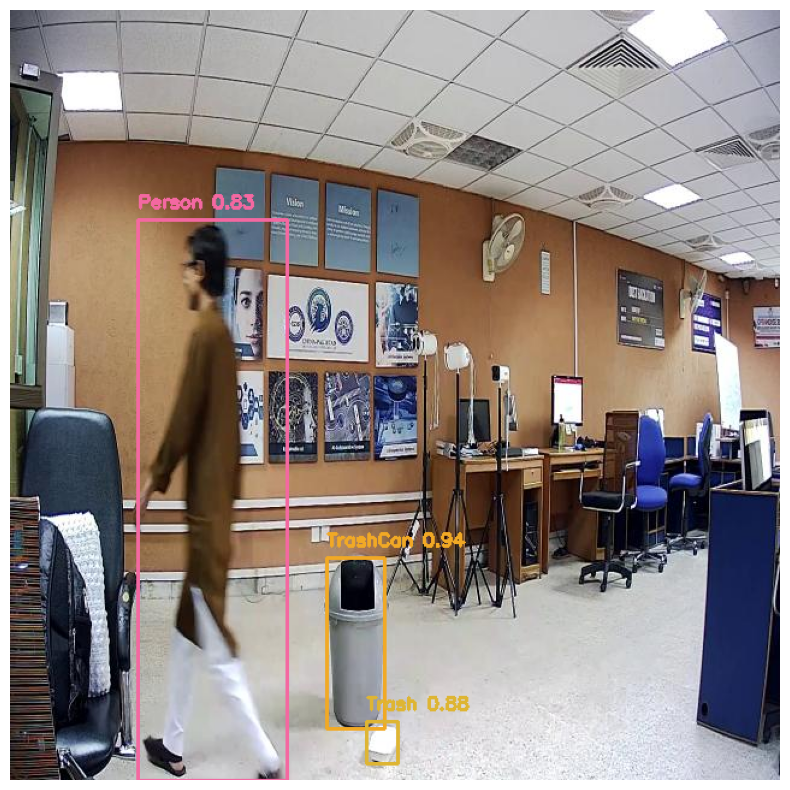

In [28]:
# Tentukan path ke file model YOLOv8 yang telah dilatih
model_path = '/content/drive/MyDrive/dataset/model_yolov8n.pt'
model = YOLO(model_path)  # Memuat model YOLOv8 yang sudah dilatih

# Fungsi untuk melakukan deteksi objek pada gambar dan menampilkan hasilnya
def detect_objects_and_display(image_path, model):
    # Membaca gambar
    image = cv2.imread(image_path)

    # Melakukan deteksi objek
    results = model(image)

    # Mendapatkan hasil deteksi
    boxes = results[0].boxes.xyxy  # Koordinat kotak pembatas (bounding box)
    confidences = results[0].boxes.conf  # Tingkat keyakinan (confidence)
    labels = results[0].boxes.cls  # Indeks label kelas

    # Menampilkan hasil deteksi
    print(f"Hasil deteksi pada {image_path}:")
    for i, (box, label, confidence) in enumerate(zip(boxes, labels, confidences)):
        print(f"Objek {i+1}:")
        print(f"  Label: {model.names[int(label)]}")  # Menampilkan nama kelas berdasarkan label
        print(f"  Confidence: {confidence:.2f}")
        print(f"  Box: {box.tolist()}")

    # Menampilkan gambar dengan bounding box
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = map(int, box.tolist())
        label_name = model.names[int(label)]  # Mendapatkan nama kelas berdasarkan label
        confidence = confidences[labels.tolist().index(label)]  # Confidence terkait dengan label

        # Pilih warna acak untuk bounding box dan label
        color = [random.randint(0, 255) for _ in range(3)]  # Membuat warna acak dalam format [B, G, R]

        # Menambahkan bounding box dengan warna acak
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        # Menambahkan label dengan confidence di dekat kotak, menggunakan warna acak
        cv2.putText(image, f"{label_name} {confidence:.2f}",
                    (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Menampilkan gambar dengan bounding box dan label
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.axis('off')
    plt.show()

# Mengambil gambar yang telah di-upload
uploaded_image_path = list(uploaded.keys())[0]

# Melakukan deteksi objek pada gambar yang di-upload
detect_objects_and_display(uploaded_image_path, model)